### Imports

In [35]:
import pandas as pd
import numpy as np
# from scipy.stats import norm

%matplotlib inline

### Functions

In [70]:
def return_calculator(df,t):
    df["prev_close"] = df["close"].shift(t)
    df["return"] = df["close"]/df["prev_close"]-1
#     df["return2"] = df["close"].pct_change(t)
    df["log_return"] = np.log(df["return"]+1)
    return df

### Read data

In [77]:
data = pd.read_csv("all_stocks_5yr.csv", parse_dates=True)

In [78]:
sbux = df[df["Name"]=="SBUX"].copy()

In [79]:
sbux.head()

,date,open,high,low,close,volume,Name
498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


1259


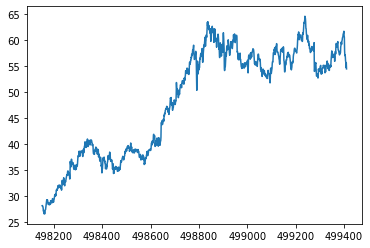

In [80]:
print(len(sbux))
sbux["close"].plot();

In [81]:
sbux = return_calculator(sbux,1)

In [82]:
# sbux["prev_close"] = sbux["close"].shift(1)
# sbux["return"] = sbux["close"]/sbux["prev_close"]-1
# sbux["return2"] = sbux["close"].pct_change(1)
# sbux["log_return"] = np.log(sbux["return"]+1)

In [83]:
sbux.head()

,date,open,high,low,close,volume,Name,prev_close,return,log_return
498152,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,NaN
498153,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,-0.004089
498154,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,0.002135
498155,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,-0.007672
498156,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,-0.005028


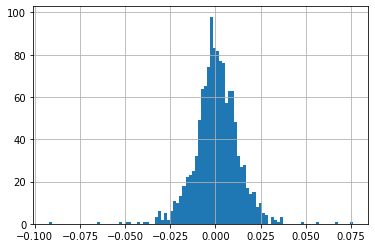

In [84]:
sbux["return"].hist(bins=100);

In [85]:
sbux["return"].mean(), sbux["return"].std()

(0.0006002332205830914, 0.012360934026133879)

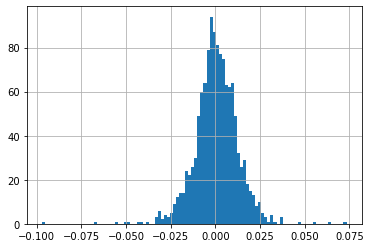

In [86]:
sbux["log_return"].hist(bins=100);

In [87]:
sbux["log_return"].mean(), sbux["log_return"].std()

(0.0005235902748108682, 0.012381234216101258)